<a href="https://colab.research.google.com/github/Martin09/DeepSEM/blob/master/nanowire_yield/2_nw_yield_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and play with it yourself. __DO NOT__ request access to this tutorial.


In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime -> "Change runtime type" menu to enable GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jun  3 08:42:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Install detectron2

In [0]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version


Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
     |████████████████████████████████| 276kB 8.4MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=43d194d9356c5d39dadff627a901cd4ba504102e5aa1c82f78f02d7ee4c3d3ff
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-37eafa6n
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-37eafa6n
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-lin

In [0]:
# install detectron2:
!pip install detectron2==0.1.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html
     |████████████████████████████████| 6.2MB 817kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200603-cp36-none-any.whl size=41026 sha256=c796a5b0fcdf7569f3b1e4eb63643906d95bad29e15205b966d8f76e87f05c1f
  Stored in directory: /root/.cache/pip/wheels/0b/6a/17/318f4c72dad2d0d7f63f8866d6c973e34e20bd24031b240b6d
Successfully built fvcore


In [0]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from glob import glob
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [a custom labelled nanowire detection dataset](https://github.com/Martin09/DeepSEM/tree/master/Datasets/NWs-8kMag-subdivided)
which only has three classes: Nanowires, Parasitic Growth and Nanospades
We'll train a nanowire detection model from an existing model pre-trained on the COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have any of these categories so we will have to perform transfer learning to get the model to detect them.

## Prepare the dataset

In [0]:
# # Clone the DeepSEM repository
# !rm -rf DeepSEM
# !git clone https://github.com/Martin09/DeepSEM

# OR

# Load from my GoogleDrive
from google.colab import drive
import sys
drive.mount('/content/gdrive/')
# sys.path.append('/content/gdrive/My Drive/LMSC/MachineLearning/Datasets')
%cd "/content/gdrive/My Drive/LMSC/MachineLearning/Colab"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/
/content/gdrive/My Drive/LMSC/MachineLearning/Colab


## Calculate mean pixel intensity of dataset



In [0]:
# Calcualte dataset mean pixel intensity
images_dir = './DeepSEM/nanowire_yield/datasets/NWs-8kMag-subdivided/'
images = glob(images_dir + '*.png')

min_pixel_intensity = np.infty
max_pixel_intensity = -np.infty
mean_pixel_intensity = 0
for img in images:
    im = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
    min_pixel_intensity = min([np.min(im), min_pixel_intensity])
    max_pixel_intensity = max([np.max(im), max_pixel_intensity])
    mean_pixel_intensity += np.mean(im)
mean_pixel_intensity /= len(images)

print('The min pixel intesity is: {:.2f}'.format(min_pixel_intensity))
print('The max pixel intesity is: {:.2f}'.format(max_pixel_intensity))
print('The mean pixel intesity is: {:.2f}'.format(mean_pixel_intensity))

The min pixel intesity is: 0.00
The max pixel intesity is: 255.00
The mean pixel intesity is: 58.33


Register the nanowire dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. See the tutorial for more details.


In [0]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

import os
import numpy as np
import json
from detectron2.structures import BoxMode

# Takes a labelbox JSON file and randomly splits it into two other JSON files, one for testing and one for validation
def test_train_split(json_file, t_out = 'train.json', v_out = 'val.json'):

    # Load output file from LabelBox
    with open(json_file) as f:
        dat = json.load(f)
    dat = [d for d in dat if d["Label"] != {}]  # Remove empty entries
    i_val = np.random.choice(len(dat), int(len(dat)*0.1))
    i_train = list(set(list(range(len(dat))))-set(i_val))
    dat_train = [dat[i] for i in i_train]
    dat_val = [dat[i] for i in i_val]
    with open(t_out, 'w') as fout:
        json.dump(dat_train, fout)
    with open(v_out, 'w') as fout:
        json.dump(dat_val, fout)      
    
    print("Exported {} training images and {} validation images!".format(len(i_train),len(i_val)))
        
def get_nw_dicts_from_labelbox(json_file):
    category_dict = {'nw':0, 'parasitic':1, 'nanospade':2}

    with open(images_dir + json_file) as f:
        img_anns = json.load(f)

    dataset_dicts = []
    for idx,img in enumerate(img_anns):
        filename = images_dir+'/'+img['External ID']
        height, width = cv2.imread(filename).shape[:2]

        record = {}
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        objs = []
        for anno in img['Label']['objects']:
            bb = anno['bbox']

            obj = {
                "bbox": [bb['left'], bb['top'], bb['width'], bb['height']],
                "bbox_mode": BoxMode.XYWH_ABS,
                "category_id": category_dict[anno['value']],
            }
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

from detectron2.data import DatasetCatalog, MetadataCatalog

json_file = './DeepSEM/nanowire_yield/datasets/export-2020-05-26T15_27_19.519Z.json'
train_out = './DeepSEM/nanowire_yield/datasets/NWs-8kMag-subdivided/nw_yield_train.json'
val_out = './DeepSEM/nanowire_yield/datasets/NWs-8kMag-subdivided/nw_yield_val.json'
test_train_split(json_file, train_out, val_out)

DatasetCatalog.clear()

for d in ["train", "val"]:
    DatasetCatalog.register("nw_yield_" + d, lambda d=d: get_nw_dicts_from_labelbox("nw_yield_" + d + ".json"))
    MetadataCatalog.get("nw_yield_" + d).set(thing_classes=["nw","parasitic","nanospade"])
nanowire_metadata = MetadataCatalog.get("nw_yield_train")

Exported 31 training images and 3 validation images!


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



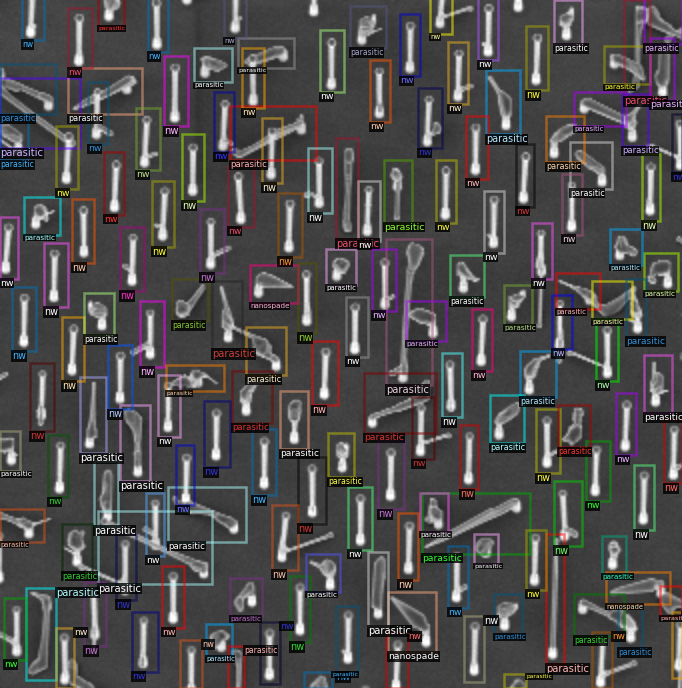

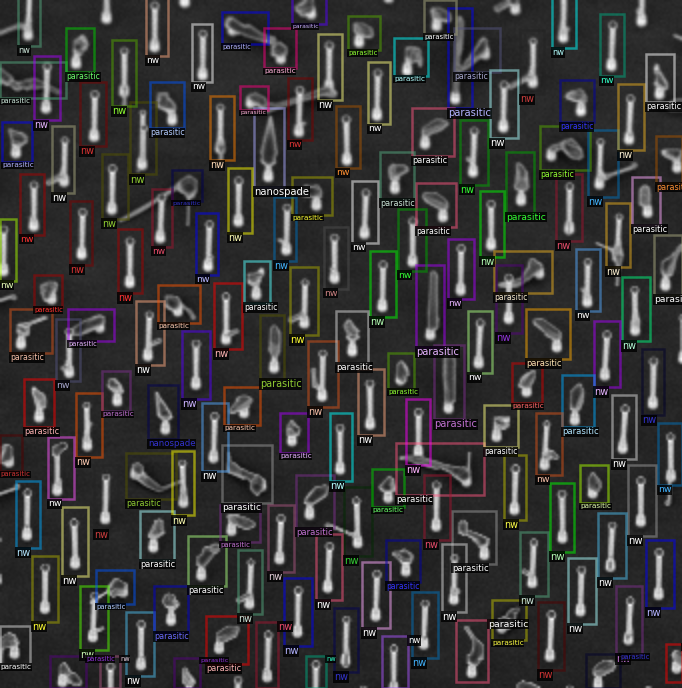

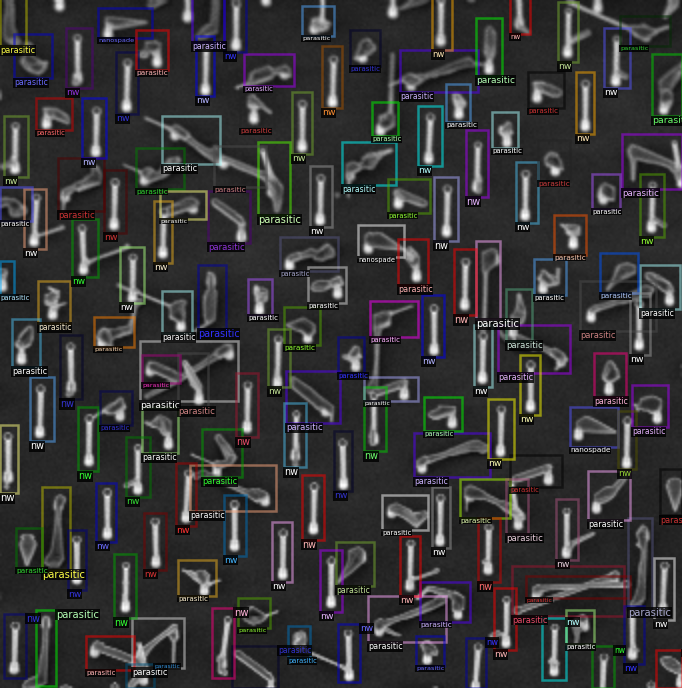

In [0]:
dataset_dicts = get_nw_dicts_from_labelbox("nw_yield_train.json")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])

    visualizer = Visualizer(img[:, :, ::-1], metadata=nanowire_metadata, scale=2.0)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Train!

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import datetime

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
output_dir = './DeepSEM/nanowire_yield/output/' + timestamp

cfg = get_cfg()
cfg.OUTPUT_DIR = output_dir
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("nw_yield_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 16
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 16
cfg.SOLVER.BASE_LR = 0.01  # learning rate
cfg.SOLVER.MAX_ITER = 100  # 1000 is decent for initial testing
cfg.SOLVER.CHECKPOINT_PERIOD = 10000  # Save a checkpoint after every this number of iterations

# Learning rate warmup and decay
cfg.SOLVER.WARMUP_FACTOR = 1/1000.  # Learning starts at BASE_LR * WU_FACTOR
cfg.SOLVER.WARMUP_ITERS = 1000  # Number of iterations for warm-up phase
cfg.SOLVER.WARMUP_METHOD = "linear"
cfg.SOLVER.GAMMA = 0.5
# cfg.SOLVER.STEPS = (100,200,300,)  # List of iteration numbers at which to decrease learning rate by factor GAMMA.
cfg.SOLVER.STEPS = tuple(range(0,cfg.SOLVER.MAX_ITER,1000))

# Validation set
cfg.TEST.EVAL_PERIOD = 0
cfg.TEST.DETECTIONS_PER_IMAGE = 1000

# Don't scale the input images
cfg2.INPUT.MIN_SIZE_TRAIN = (0,)  # Keep these data types or might run into issues during inference when loading config file
cfg2.INPUT.MAX_SIZE_TRAIN = 99999  # Keep these data types or might run into issues during inference when loading config file

cfg.MODEL.RPN.IN_FEATURES = ['p2', 'p2', 'p3', 'p4', 'p5', 'p6']
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.25, 0.5, 1.0, 2.0, 4.0, 8.0]]
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[4], [8], [16], [32], [64], [128]]
cfg.MODEL.PIXEL_MEAN = [58.33, 58.33, 58.33] 
cfg.MODEL.PIXEL_STD = [1.0, 1.0, 1.0]
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4096
cfg.MODEL.ROI_HEADS.POSITIVE_FRACTION = 0.5
cfg.MODEL.ROI_HEADS.IOU_THRESHOLDS = [0.5] # Intersection over union threshold
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 # We have three classification classes 
cfg.MODEL.RPN.POST_NMS_TOPK_TRAIN = 4000
cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN = 4000

In [0]:
# Look at training curves in tensorboard:
%load_ext tensorboard
# %reload_ext tensorboard
%tensorboard --logdir ./DeepSEM/nanowire_yield/output

<IPython.core.display.Javascript object>

In [0]:
# Start training
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()
torch.save(trainer.model, 'test.pth')

[06/03 08:44:49 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:18, 9.26MB/s]                           
Unable to load 'proposal_generator.anchor_generator.cell_anchors.0' to the model due to incompatible shapes: (3, 4) in the checkpoint but (6, 4) in the model!
Unable to load 'proposal_generator.anchor_generator.cell_anchors.1' to the model due to incompatible shapes: (3, 4) in the checkpoint but (6, 4) in the model!
Unable to load 'proposal_generator.anchor_generator.cell_anchors.2' to the model due to incompatible shapes: (3, 4) in the checkpoint but (6, 4) in the model!
Unable to load 'proposal_generator.anchor_generator.cell_anchors.3' to the model due to incompatible shapes: (3, 4) in the checkpoint but (6, 4) in the model!
Unable to load 'proposal_generator.anchor_generator.cell_anchors.4' to the model due to incompatible shapes: (3, 4) in the checkpoint but (6, 4) in the model!
Unable to load 'proposal_generator.rpn_head.objectness_logits.weight' to the model due to incompatible shapes: (3, 256, 1, 1) in t

[06/03 08:45:16 d2.engine.train_loop]: Starting training from iteration 0
[06/03 08:45:56 d2.utils.events]:  eta: 0:02:39  iter: 19  total_loss: 1.831  loss_cls: 0.724  loss_box_reg: 0.021  loss_rpn_cls: 0.654  loss_rpn_loc: 0.432  time: 1.9664  data_time: 0.1316  lr: 0.000100  max_mem: 8815M
[06/03 08:46:37 d2.utils.events]:  eta: 0:02:01  iter: 39  total_loss: 1.534  loss_cls: 0.380  loss_box_reg: 0.212  loss_rpn_cls: 0.574  loss_rpn_loc: 0.344  time: 1.9886  data_time: 0.1040  lr: 0.000200  max_mem: 8815M
[06/03 08:47:16 d2.utils.events]:  eta: 0:01:21  iter: 59  total_loss: 1.321  loss_cls: 0.280  loss_box_reg: 0.245  loss_rpn_cls: 0.470  loss_rpn_loc: 0.316  time: 1.9849  data_time: 0.1004  lr: 0.000300  max_mem: 8815M
[06/03 08:47:55 d2.utils.events]:  eta: 0:00:41  iter: 79  total_loss: 1.112  loss_cls: 0.229  loss_box_reg: 0.257  loss_rpn_cls: 0.321  loss_rpn_loc: 0.299  time: 1.9770  data_time: 0.1121  lr: 0.000400  max_mem: 8815M
[06/03 08:48:36 d2.utils.events]:  eta: 0:00:0

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the nanowire yield validation dataset. First, let's create a predictor using the model we just trained:



In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # Set the testing threshold for this model
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.2     # Non-max supression threshold
cfg.DATASETS.TEST = ("nw_yield_val", )
cfg.TEST.DETECTIONS_PER_IMAGE = 200
cfg.INPUT.MIN_SIZE_TEST = 0
cfg.INPUT.MAX_SIZE_TEST = 99999
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

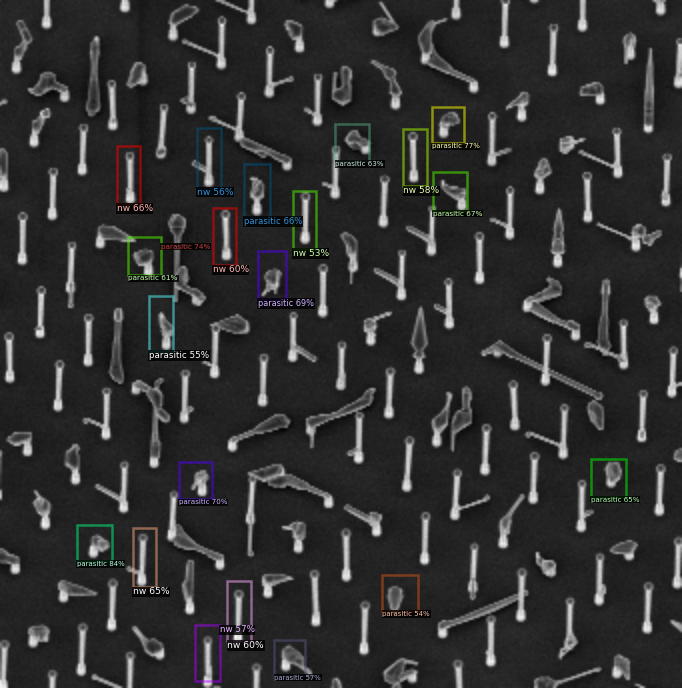

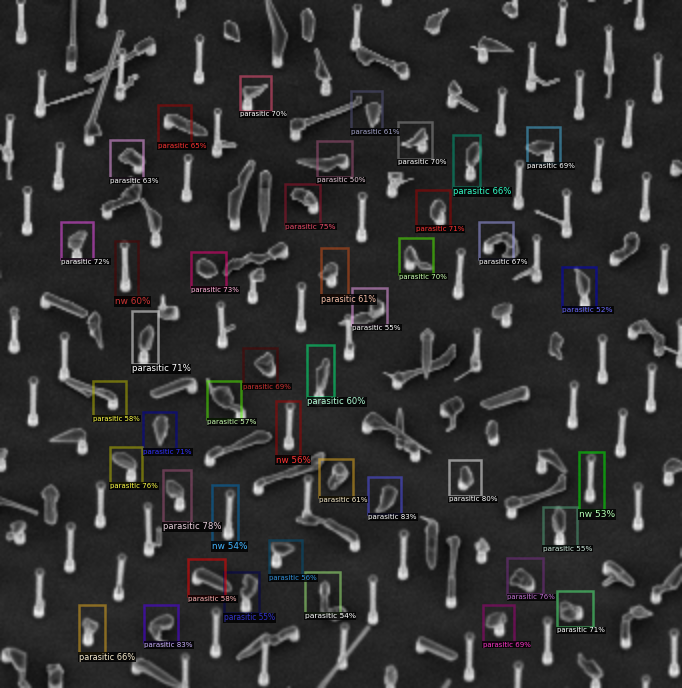

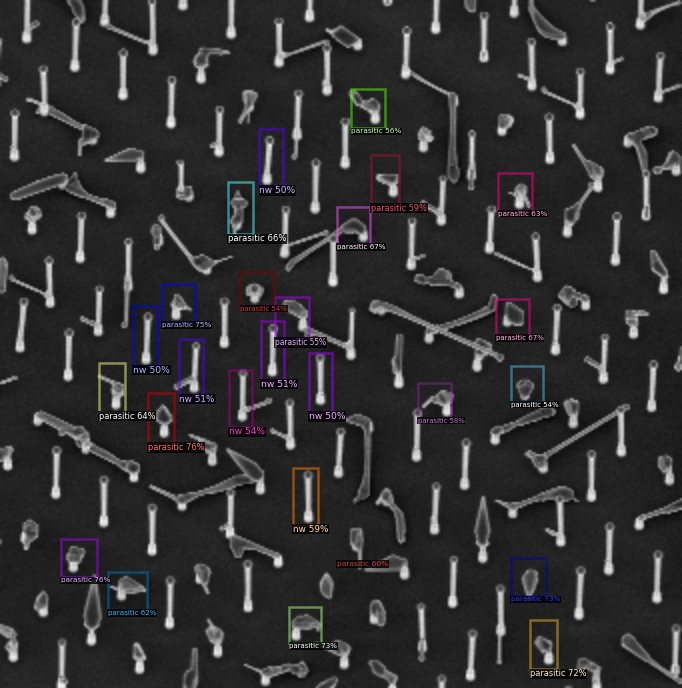

In [0]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_nw_dicts_from_labelbox("nw_yield_val.json")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=nanowire_metadata, 
                   scale=2.0, 
                  #  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

We can also evaluate its performance using AP metric implemented in COCO API.

[NOT WORKING YET]

In [0]:
# ## Not working yet
# from detectron2.evaluation import COCOEvaluator, inference_on_dataset
# from detectron2.data import build_detection_test_loader
# evaluator = COCOEvaluator("nw_yield_train", cfg, False)#, output_dir="./output/")
# val_loader = build_detection_test_loader(cfg, "nw_yield_train")
# inference_on_dataset(trainer.model, val_loader, evaluator)
# # another equivalent way is to use trainer.test

In [0]:
# # Check the outputs of the neural network manually:
# outputs["instances"].pred_boxes
# outputs["instances"].scores
# outputs["instances"].pred_classes

In [0]:
weights_source = cfg.OUTPUT_DIR + '/model_final.pth'
model_name = 'nw_yield_it'+str(trainer.iter)+'_loss0.93.yaml'
model_dest = './DeepSEM/nanowire_yield/trained_models/' + model_name

# Move weights file to "trained_models" folder and update the config file accordingly
weights_dest = model_dest[:-5] + '.pth'

!cp $weights_source $weights_dest
cfg.MODEL.WEIGHTS = weights_dest

# Save the config file alongside the weights file
confi_dest = model_dest
with open(confi_dest, "w") as text_file:
    text_file.write(cfg.dump())

NameError: ignored